## Compare transports between control and GPC015

I am using some of Adele's scripts to calculate the transport in sigma 1 coordinates over the 1000m isobath. The scripts are located at `/home/156/cy8964/x77/Analysis/cross_slope_transports`. These are run each month and the output is in `/g/data/x77/cy8964/Post_Process/access-om2/##EXPT##` in monthly files.



In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
from dask.distributed import Client
import cmocean as cm


In [2]:
client = Client(n_workers=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46723,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:38565,Total threads: 4
Dashboard: /proxy/36353/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:41761,


### Make database

In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

In [4]:
# build database for basal melt experiments:
session_name = '/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
#'/g/data/x77/cy8964/databases/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)
# dir_list = ['/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC004/',
#            '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC005/',
#            '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC006/',
#            '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC007/',
#            '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC008/',
#            '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC013/',
#            '/g/data/ik11/outputs/access-om2-01/basal_melt_outputs/accessom2-GPC015/accessom2-GPC015/'
#            ]
# cc.database.build_index(dir_list,basal_melt_session)


In [5]:
cc.querying.get_variables(basal_melt_session, experiment='accessom2-GPC015', frequency='1 monthly')


,name,long_name,units,frequency,ncfile,cell_methods,# ncfiles,time_start,time_end
0,ANGLE,angle grid makes with latitude line on U grid,radians,1 monthly,output1116/ice/OUTPUT/iceh.2169-12.nc,None,240,2150-01-01 00:00:00,2170-01-01 00:00:00
1,ANGLET,angle grid makes with latitude line on T grid,radians,1 monthly,output1116/ice/OUTPUT/iceh.2169-12.nc,None,240,2150-01-01 00:00:00,2170-01-01 00:00:00
2,HTE,T cell width on East side,m,1 monthly,output1116/ice/OUTPUT/iceh.2169-12.nc,None,240,2150-01-01 00:00:00,2170-01-01 00:00:00
3,HTN,T cell width on North side,m,1 monthly,output1116/ice/OUTPUT/iceh.2169-12.nc,None,240,2150-01-01 00:00:00,2170-01-01 00:00:00
4,NCAT,category maximum thickness,m,1 monthly,output1116/ice/OUTPUT/iceh.2169-12.nc,None,240,2150-01-01 00:00:00,2170-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...
173,xt_ocean_sub01,tcell longitude,degrees_E,1 monthly,output1116/ocean/rregionocean_monthly_2d_basal.nc,None,120,2150-01-01 00:00:00,2170-01-01 00:00:00
174,xu_ocean,ucell longitude,degrees_E,1 monthly,output1116/ocean/ocean.nc,None,240,2150-01-01 00:00:00,2170-01-01 00:00:00
175,yt_ocean,tcell latitude,degrees_N,1 monthly,output1116/ocean/ocean.nc,None,360,2150-01-01 00:00:00,2170-01-01 00:00:00
176,yt_ocean_sub01,tcell latitude,degrees_N,1 monthly,output1116/ocean/rregionocean_monthly_2d_basal.nc,None,120,2150-01-01 00:00:00,2170-01-01 00:00:00


### First plot contour

In [6]:
### Load Ade?le's isobath contour
isobath_depth = 1000
outfile = '/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_'+str(isobath_depth)+'m.npz'
data = np.load(outfile)
mask_y_transport = data['mask_y_transport']
mask_x_transport = data['mask_x_transport']

In [7]:
lat_range = slice(-90,-59)

Text(0.5, 1.0, '1000m isobath contour')

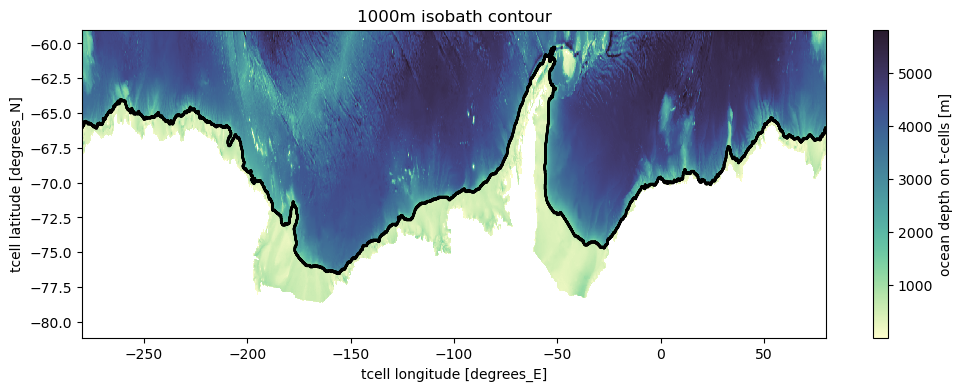

In [8]:
ht = cc.querying.getvar(control, 'ht',master_session, n=1, ncfile = 'ocean_grid.nc')
ht = ht.sel(yt_ocean=lat_range)
yt_ocean = cc.querying.getvar(control, 'yt_ocean',master_session, n=1, ncfile = 'ocean_grid.nc')
xt_ocean = cc.querying.getvar(control, 'xt_ocean',master_session, n=1, ncfile = 'ocean_grid.nc')
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)


fig, axes = plt.subplots(figsize = (12,4))
ht.plot(ax = axes, cmap = cm.cm.deep)
axes.contour(xt_ocean.values, yt_ocean.values,np.abs(mask_x_transport)+np.abs(mask_y_transport),colors = 'k')
axes.set_title('1000m isobath contour')
#plt.savefig('contour.png', dpi = 300)

### Plot control transports

In [9]:
## load control transports from Adele's easterlies folder

test = xr.open_mfdataset('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_rerun_for_easterlies/Antarctic_cross_slope/vol_trans_across_contour_2150_01.nc').vol_trans_across_contour_binned
vol_trans_across_contour = xr.zeros_like(test)
count_days = 0
# load 10 year (10 years x 12 months)
for j in np.arange(2150,2160):
    for i in np.arange(1,13):
        it = xr.open_mfdataset('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_rerun_for_easterlies/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
        vol_trans_across_contour = vol_trans_across_contour + it.vol_trans_across_contour_binned*it.ndays
        count_days = count_days + it.ndays.values
# divide by total of number of days in each month for correct annual average    
vol_trans_across_contour = vol_trans_across_contour/count_days
vol_trans_across_contour

<xarray.DataArray (isopycnal_bins: 132, contour_index: 6002)>
dask.array<truediv, shape=(132, 6002), dtype=float64, chunksize=(132, 6002), chunktype=numpy.ndarray>
Coordinates:
  * isopycnal_bins  (isopycnal_bins) float64 1.0 27.0 27.1 ... 32.78 32.79 40.0
  * contour_index   (contour_index) int64 1 2 3 4 5 ... 5998 5999 6000 6001 6002

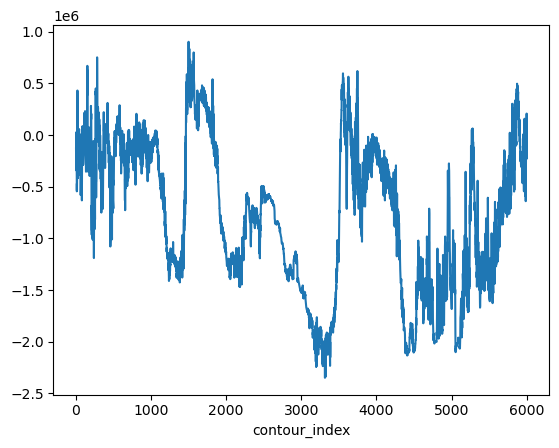

In [10]:
vol_trans_across_contour.sum('isopycnal_bins').cumsum('contour_index').plot()

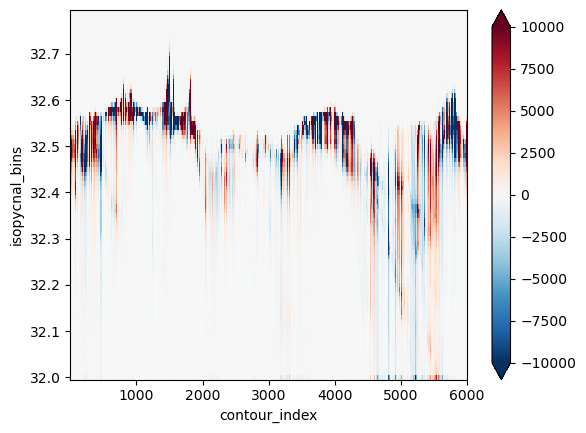

In [11]:
vol_trans_across_contour.sel(isopycnal_bins = slice(32,34)).plot(vmax = 10000)

Text(0.5, 1.0, 'Off-shore transport, integrated cumulatively \nfrom densest to lightest')

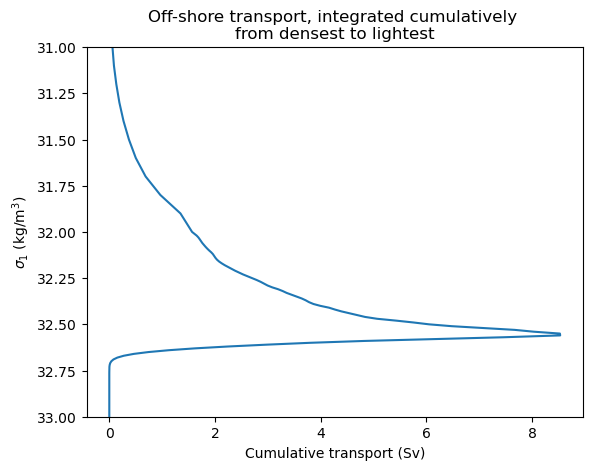

In [12]:
a = (vol_trans_across_contour/1e6).sum('contour_index')
(a.sum('isopycnal_bins') -a.cumsum('isopycnal_bins')).plot(y = 'isopycnal_bins')
plt.ylim(33,31)
plt.xlabel('Cumulative transport (Sv)')
plt.ylabel('$\sigma_1$ (kg/m$^3$)')
plt.title('Off-shore transport, integrated cumulatively \nfrom densest to lightest')


### Make nicer y axis than `contour_index` by loading in lon/lat/distance of contour

according to cosima recipes https://nbviewer.org/github/claireyung/cosima-recipes/blob/master/DocumentedExamples/Cross-contour_transport.ipynb

In [13]:
expt = control
session = master_session

In [14]:
mask_y_transport = data['mask_y_transport']
mask_x_transport = data['mask_x_transport']
mask_y_transport_numbered = data['mask_y_transport_numbered']
mask_x_transport_numbered = data['mask_x_transport_numbered']

yt_ocean = cc.querying.getvar(expt,'yt_ocean',session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
yu_ocean = cc.querying.getvar(expt,'yu_ocean',session,n=1)
yu_ocean = yu_ocean.sel(yu_ocean=lat_range)
xt_ocean = cc.querying.getvar(expt,'xt_ocean',session,n=1)
xu_ocean = cc.querying.getvar(expt,'xu_ocean',session,n=1)

# Convert contour masks to data arrays, so we can multiply them later.
# We need to ensure the lat lon coordinates correspond to the actual data location:
#       The y masks are used for vhrho, so like vhrho this should have dimensions (yu_ocean, xt_ocean).
#       The x masks are used for uhrho, so like uhrho this should have dimensions (yt_ocean, xu_ocean).
#       However the actual name will always be simply y_ocean/x_ocean irrespective of the variable
#       to make concatenation of transports in both direction and sorting possible.

mask_x_transport = xr.DataArray(mask_x_transport, coords = [yt_ocean, xu_ocean], dims=['y_ocean', 'x_ocean'])
mask_y_transport = xr.DataArray(mask_y_transport, coords = [yu_ocean, xt_ocean], dims=['y_ocean', 'x_ocean'])
mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered, coords = [yt_ocean, xu_ocean], dims=['y_ocean', 'x_ocean'])
mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered, coords = [yu_ocean, xt_ocean], dims=['y_ocean', 'x_ocean'])

# ### Stack contour data into 1D

# Create the contour order data-array. Note that in this procedure the x-grid counts have x-grid
#   dimensions and the y-grid counts have y-grid dimensions, but these are implicit, the dimension 
#   *names* are kept general across the counts, the generic y_ocean, x_ocean, so that concatening works
#   but we dont double up with numerous counts for one lat/lon point.

# stack contour data into 1d:
mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)
mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)
contour_ordering = xr.concat((mask_x_numbered_1d,mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1,len(contour_ordering)+1)

# get lat and lon along contour, useful for plotting later:
lat_along_contour = contour_ordering.y_ocean
lon_along_contour = contour_ordering.x_ocean
# don't need the multi-index anymore, replace with contour count
lat_along_contour.coords['contour_index'] = contour_index_array
lon_along_contour.coords['contour_index'] = contour_index_array



In [15]:
# ## save distance - this takes time

# dxu = cc.querying.getvar(expt,'dxu',session,ncfile = 'ocean_grid.nc',n=1)
# dxu = dxu.sel(yu_ocean = lat_range)
# dyt = cc.querying.getvar(expt,'dyt',session,ncfile = 'ocean_grid.nc',n=1)
# dyt = dyt.sel(yt_ocean = lat_range)
# num_points = len(lat_along_contour)
# lat_t = cc.querying.getvar(expt,'geolat_t',session,ncfile = 'ocean_grid.nc',n=1)
# lat_t = lat_t.sel(yt_ocean = lat_range)
# lon_t = cc.querying.getvar(expt,'geolon_t',session,ncfile = 'ocean_grid.nc',n=1)
# lon_t = lon_t.sel(yt_ocean = lat_range)

# # if there is a bend in the contour, add the distance using length of diagonal, not sum of
# # 2 edges, to be more representative.    
# distance_along_contour = np.zeros((num_points))
# x_indices = np.sort(mask_x_transport_numbered.values[mask_x_transport_numbered.values>0])
# y_indices = np.sort(mask_y_transport_numbered.values[mask_y_transport_numbered.values>0])
# skip = False
# for count in range(1,num_points):
#     if skip == True:
#         skip = False
#         continue
#     if count in y_indices:
#         if count + 1 in y_indices:
#             # note dxu and dyt do no vary in x:
#             jj = np.where(mask_y_transport_numbered==count)[0]
#             distance_along_contour[count-1] = (dxu[jj,990])[0]
#         else:
#             jj0 = np.where(mask_y_transport_numbered==count)[0]
#             jj1 = np.where(mask_x_transport_numbered==count+1)[0]
#             diagonal_distance = 0.5*np.sqrt((dxu[jj0,990])[0]**2+\
#                 (dyt[jj1,990])[0]**2)
#             distance_along_contour[count-1] = diagonal_distance
#             distance_along_contour[count] = diagonal_distance
#             # skip to next count:
#             skip = True
#     # count in x_indices:
#     else:
#         if count + 1 in x_indices:
#             jj = np.where(mask_x_transport_numbered==count)[0]
#             distance_along_contour[count-1] = (dyt[jj,990])[0]
#         else:
#             jj0 = np.where(mask_x_transport_numbered==count)[0]
#             jj1 = np.where(mask_y_transport_numbered==count+1)[0]
#             diagonal_distance = 0.5*np.sqrt((dyt[jj0,990])[0]**2+\
#                 (dxu[jj1,990])[0]**2)
#             distance_along_contour[count-1] = diagonal_distance
#             distance_along_contour[count] = diagonal_distance
#             # skip to next count:
#             skip = True
# # fix last value:
# if distance_along_contour[-1] == 0:
#     count = count + 1
#     if count in y_indices:
#         jj = np.where(mask_y_transport_numbered==count)[0]
#         distance_along_contour[-1] = (dxu[jj,990])[0]
#     else:
#         jj = np.where(mask_x_transport_numbered==count)[0]
#         distance_along_contour[-1] = (dyt[jj,990])[0]

# # units are 10^3 km:
# distance_along_contour = np.cumsum(distance_along_contour)/1e3/1e3 
# #save_dir = '/g/data/x77/cy8964/Post_Process/access-om2/'
# #ds_latlondist = xr.Dataset({'distance_along_contour': distance_along_contour})
# #ds_latlondist.to_netcdf(save_dir+'1000m_isobath_contour_distance.nc')

In [16]:
distance_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/access-om2/1000m_isobath_contour_distance.nc').distance_along_contour

In [17]:
distance_indices = np.zeros(8)
for i in np.arange(100,len(lon_along_contour.values)):
    if (distance_indices[1]==0):
        if (lon_along_contour.values[i]>-240):
            distance_indices[1] = lon_along_contour.contour_index.values[i]
    if (distance_indices[2]==0):
        if (lon_along_contour.values[i]>-180):
            distance_indices[2] = lon_along_contour.contour_index.values[i]
    if (distance_indices[3]==0):
        if (lon_along_contour.values[i]>-120):
            distance_indices[3] = lon_along_contour.contour_index.values[i]
    if (distance_indices[4]==0):
        if lon_along_contour.values[i]>-60:
            distance_indices[4] = lon_along_contour.contour_index.values[i]
    if (distance_indices[5]==0):
        if (lon_along_contour.values[i]>0):
            distance_indices[5] = lon_along_contour.contour_index.values[i]
    if (distance_indices[6]==0):
        if (lon_along_contour.values[i]>60):
            distance_indices[6] = lon_along_contour.contour_index.values[i]
distance_indices[7] = len(lon_along_contour.contour_index.values)-1


Text(0.5, 0, 'Longitude coordinates along contour')

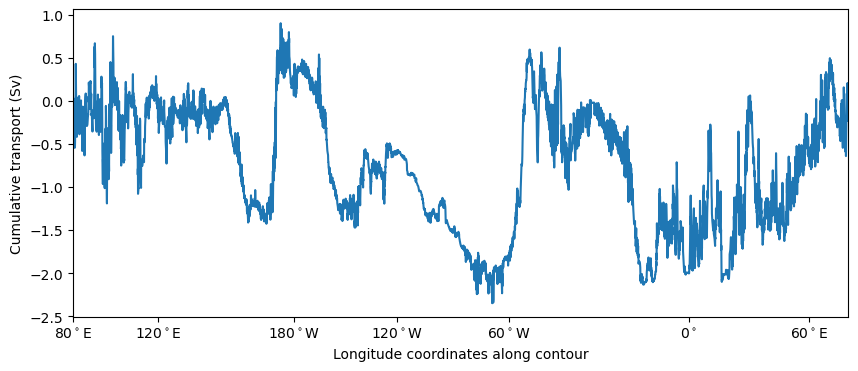

In [18]:
fig, axes = plt.subplots(figsize = (10,4))

axes.plot(distance_along_contour,(10**(-6)*vol_trans_across_contour.sum('isopycnal_bins').cumsum('contour_index')))
axes.set_ylabel('Cumulative transport (Sv)')
axes.set_xticks(distance_along_contour[distance_indices.astype(int)[:-1]])
axes.set_xticklabels(('80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'));
axes.set_xlim(0,distance_along_contour[-1]);
axes.set_xlabel('Longitude coordinates along contour')


### Load GPC015

In [19]:
## load gpc015 results
no = 15
test = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/accessom2-GPC'+str(no).zfill(3)+'/Antarctic_cross_slope/vol_trans_across_contour_2150_01.nc').vol_trans_across_contour_binned
vol_trans_across_contour_GPC015 = xr.zeros_like(test)
count_days = 0
# load ten year (10 years x 12 months)
for j in np.arange(2150,2170):
    for i in np.arange(1,13):
        if j == 2167:
            exit
        else:
            it = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/accessom2-GPC'+str(no).zfill(3)+'/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
            vol_trans_across_contour_GPC015 = vol_trans_across_contour_GPC015 + it.vol_trans_across_contour_binned*it.ndays
            count_days = count_days + it.ndays.values
# divide by total of number of days in each month for correct annual average    
vol_trans_across_contour_GPC015 = vol_trans_across_contour_GPC015/count_days
vol_trans_across_contour_GPC015

<xarray.DataArray (isopycnal_bins: 132, contour_index: 6002)>
dask.array<truediv, shape=(132, 6002), dtype=float64, chunksize=(132, 6002), chunktype=numpy.ndarray>
Coordinates:
  * isopycnal_bins  (isopycnal_bins) float64 1.0 27.0 27.1 ... 32.78 32.79 40.0
  * contour_index   (contour_index) int64 1 2 3 4 5 ... 5998 5999 6000 6001 6002

In [22]:
## load individual years
test = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/accessom2-GPC015/Antarctic_cross_slope/vol_trans_across_contour_2150_01.nc').vol_trans_across_contour_binned

vol_trans_across_contour_GPC013_yr1 = xr.zeros_like(test)
count_days = 0
for j in np.arange(2150,2151):
    for i in np.arange(1,13):
        it = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/accessom2-GPC015/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
        vol_trans_across_contour_GPC013_yr1 = vol_trans_across_contour_GPC013_yr1 + it.vol_trans_across_contour_binned*it.ndays
        count_days = count_days + it.ndays.values
# divide by total of number of days in each month for correct annual average    
vol_trans_across_contour_GPC013_yr1 = vol_trans_across_contour_GPC013_yr1/count_days

vol_trans_across_contour_GPC013_yr2 = xr.zeros_like(test)
count_days = 0
for j in np.arange(2151,2152):
    for i in np.arange(1,13):
        it = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/accessom2-GPC015/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
        vol_trans_across_contour_GPC013_yr2 = vol_trans_across_contour_GPC013_yr2 + it.vol_trans_across_contour_binned*it.ndays
        count_days = count_days + it.ndays.values
# divide by total of number of days in each month for correct annual average    
vol_trans_across_contour_GPC013_yr2 = vol_trans_across_contour_GPC013_yr2/count_days

vol_trans_across_contour_GPC013_yr3 = xr.zeros_like(test)
count_days = 0
for j in np.arange(2152,2153):
    for i in np.arange(1,13):
        it = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/accessom2-GPC015/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
        vol_trans_across_contour_GPC013_yr3 = vol_trans_across_contour_GPC013_yr3 + it.vol_trans_across_contour_binned*it.ndays
        count_days = count_days + it.ndays.values
# divide by total of number of days in each month for correct annual average    
vol_trans_across_contour_GPC013_yr3 = vol_trans_across_contour_GPC013_yr3/count_days

vol_trans_across_contour_GPC013_yr4 = xr.zeros_like(test)
count_days = 0
for j in np.arange(2153,2154):
    for i in np.arange(1,13):
        it = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/accessom2-GPC015/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
        vol_trans_across_contour_GPC013_yr4 = vol_trans_across_contour_GPC013_yr4 + it.vol_trans_across_contour_binned*it.ndays
        count_days = count_days + it.ndays.values
# divide by total of number of days in each month for correct annual average    
vol_trans_across_contour_GPC013_yr4 = vol_trans_across_contour_GPC013_yr4/count_days

vol_trans_across_contour_GPC013_yr5 = xr.zeros_like(test)
count_days = 0
for j in np.arange(2154,2155):
    for i in np.arange(1,13):
        it = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/accessom2-GPC015/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
        vol_trans_across_contour_GPC013_yr5 = vol_trans_across_contour_GPC013_yr5 + it.vol_trans_across_contour_binned*it.ndays
        count_days = count_days + it.ndays.values
# divide by total of number of days in each month for correct annual average    
vol_trans_across_contour_GPC013_yr5 = vol_trans_across_contour_GPC013_yr5/count_days

vol_trans_across_contour_GPC013_yr6 = xr.zeros_like(test)
count_days = 0
for j in np.arange(2155,2156):
    for i in np.arange(1,13):
        it = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/accessom2-GPC015/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
        vol_trans_across_contour_GPC013_yr6 = vol_trans_across_contour_GPC013_yr6 + it.vol_trans_across_contour_binned*it.ndays
        count_days = count_days + it.ndays.values
# divide by total of number of days in each month for correct annual average    
vol_trans_across_contour_GPC013_yr6 = vol_trans_across_contour_GPC013_yr6/count_days

vol_trans_across_contour_GPC013_yr7 = xr.zeros_like(test)
count_days = 0
for j in np.arange(2156,2157):
    for i in np.arange(1,13):
        it = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/accessom2-GPC015/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
        vol_trans_across_contour_GPC013_yr7 = vol_trans_across_contour_GPC013_yr7 + it.vol_trans_across_contour_binned*it.ndays
        count_days = count_days + it.ndays.values
# divide by total of number of days in each month for correct annual average    
vol_trans_across_contour_GPC013_yr7 = vol_trans_across_contour_GPC013_yr7/count_days

vol_trans_across_contour_GPC013_yr8 = xr.zeros_like(test)
count_days = 0
for j in np.arange(2157,2158):
    for i in np.arange(1,13):
        it = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/accessom2-GPC015/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
        vol_trans_across_contour_GPC013_yr8 = vol_trans_across_contour_GPC013_yr8 + it.vol_trans_across_contour_binned*it.ndays
        count_days = count_days + it.ndays.values
# divide by total of number of days in each month for correct annual average    
vol_trans_across_contour_GPC013_yr8 = vol_trans_across_contour_GPC013_yr8/count_days

vol_trans_across_contour_GPC013_yr9 = xr.zeros_like(test)
count_days = 0
for j in np.arange(2158,2159):
    for i in np.arange(1,13):
        it = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/accessom2-GPC015/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
        vol_trans_across_contour_GPC013_yr9 = vol_trans_across_contour_GPC013_yr9 + it.vol_trans_across_contour_binned*it.ndays
        count_days = count_days + it.ndays.values
# divide by total of number of days in each month for correct annual average    
vol_trans_across_contour_GPC013_yr9 = vol_trans_across_contour_GPC013_yr9/count_days

vol_trans_across_contour_GPC013_yr10 = xr.zeros_like(test)
count_days = 0
for j in np.arange(2159,2160):
    for i in np.arange(1,13):
        it = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/accessom2-GPC015/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
        vol_trans_across_contour_GPC013_yr10 = vol_trans_across_contour_GPC013_yr10 + it.vol_trans_across_contour_binned*it.ndays
        count_days = count_days + it.ndays.values
# divide by total of number of days in each month for correct annual average    
vol_trans_across_contour_GPC013_yr10 = vol_trans_across_contour_GPC013_yr10/count_days

vol_trans_across_contour_GPC013_yr11 = xr.zeros_like(test)
count_days = 0
for j in np.arange(2160,2161):
    for i in np.arange(1,13):
        it = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/accessom2-GPC015/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
        vol_trans_across_contour_GPC013_yr11 = vol_trans_across_contour_GPC013_yr11 + it.vol_trans_across_contour_binned*it.ndays
        count_days = count_days + it.ndays.values
# divide by total of number of days in each month for correct annual average    
vol_trans_across_contour_GPC013_yr11 = vol_trans_across_contour_GPC013_yr11/count_days

vol_trans_across_contour_GPC013_yr12 = xr.zeros_like(test)
count_days = 0
for j in np.arange(2161,2162):
    for i in np.arange(1,13):
        it = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/accessom2-GPC015/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
        vol_trans_across_contour_GPC013_yr12 = vol_trans_across_contour_GPC013_yr12 + it.vol_trans_across_contour_binned*it.ndays
        count_days = count_days + it.ndays.values
# divide by total of number of days in each month for correct annual average    
vol_trans_across_contour_GPC013_yr12 = vol_trans_across_contour_GPC013_yr12/count_days

vol_trans_across_contour_GPC013_yr13 = xr.zeros_like(test)
count_days = 0
for j in np.arange(2162,2163):
    for i in np.arange(1,13):
        it = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/accessom2-GPC015/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
        vol_trans_across_contour_GPC013_yr13 = vol_trans_across_contour_GPC013_yr13 + it.vol_trans_across_contour_binned*it.ndays
        count_days = count_days + it.ndays.values
# divide by total of number of days in each month for correct annual average    
vol_trans_across_contour_GPC013_yr13 = vol_trans_across_contour_GPC013_yr13/count_days

vol_trans_across_contour_GPC013_yr14 = xr.zeros_like(test)
count_days = 0
for j in np.arange(2163,2164):
    for i in np.arange(1,13):
        it = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/accessom2-GPC015/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
        vol_trans_across_contour_GPC013_yr14 = vol_trans_across_contour_GPC013_yr14 + it.vol_trans_across_contour_binned*it.ndays
        count_days = count_days + it.ndays.values
# divide by total of number of days in each month for correct annual average    
vol_trans_across_contour_GPC013_yr14 = vol_trans_across_contour_GPC013_yr14/count_days

vol_trans_across_contour_GPC013_yr15 = xr.zeros_like(test)
count_days = 0
for j in np.arange(2164,2165):
    for i in np.arange(1,13):
        it = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/accessom2-GPC015/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
        vol_trans_across_contour_GPC013_yr15 = vol_trans_across_contour_GPC013_yr15 + it.vol_trans_across_contour_binned*it.ndays
        count_days = count_days + it.ndays.values
# divide by total of number of days in each month for correct annual average    
vol_trans_across_contour_GPC013_yr15 = vol_trans_across_contour_GPC013_yr15/count_days

vol_trans_across_contour_GPC013_yr16 = xr.zeros_like(test)
count_days = 0
for j in np.arange(2165,2166):
    for i in np.arange(1,13):
        it = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/accessom2-GPC015/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
        vol_trans_across_contour_GPC013_yr16 = vol_trans_across_contour_GPC013_yr16 + it.vol_trans_across_contour_binned*it.ndays
        count_days = count_days + it.ndays.values
# divide by total of number of days in each month for correct annual average    
vol_trans_across_contour_GPC013_yr16 = vol_trans_across_contour_GPC013_yr16/count_days

vol_trans_across_contour_GPC013_yr17 = xr.zeros_like(test)
count_days = 0
for j in np.arange(2166,2167):
    for i in np.arange(1,13):
        it = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/accessom2-GPC015/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
        vol_trans_across_contour_GPC013_yr17 = vol_trans_across_contour_GPC013_yr17 + it.vol_trans_across_contour_binned*it.ndays
        count_days = count_days + it.ndays.values
# divide by total of number of days in each month for correct annual average    
vol_trans_across_contour_GPC013_yr17 = vol_trans_across_contour_GPC013_yr17/count_days

# vol_trans_across_contour_GPC013_yr18 = xr.zeros_like(test)
# count_days = 0
# for j in np.arange(2167,2168):
#     for i in np.arange(1,13):
#         it = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/accessom2-GPC015/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
#         vol_trans_across_contour_GPC013_yr18 = vol_trans_across_contour_GPC013_yr18 + it.vol_trans_across_contour_binned*it.ndays
#         count_days = count_days + it.ndays.values
# # divide by total of number of days in each month for correct annual average    
# vol_trans_across_contour_GPC013_yr18 = vol_trans_across_contour_GPC013_yr18/count_days

vol_trans_across_contour_GPC013_yr19 = xr.zeros_like(test)
count_days = 0
for j in np.arange(2168,2169):
    for i in np.arange(1,13):
        it = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/accessom2-GPC015/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
        vol_trans_across_contour_GPC013_yr19 = vol_trans_across_contour_GPC013_yr19 + it.vol_trans_across_contour_binned*it.ndays
        count_days = count_days + it.ndays.values
# divide by total of number of days in each month for correct annual average    
vol_trans_across_contour_GPC013_yr19 = vol_trans_across_contour_GPC013_yr19/count_days

vol_trans_across_contour_GPC013_yr20 = xr.zeros_like(test)
count_days = 0
for j in np.arange(2169,2170):
    for i in np.arange(1,13):
        it = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/accessom2-GPC015/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
        vol_trans_across_contour_GPC013_yr20 = vol_trans_across_contour_GPC013_yr20 + it.vol_trans_across_contour_binned*it.ndays
        count_days = count_days + it.ndays.values
# divide by total of number of days in each month for correct annual average    
vol_trans_across_contour_GPC013_yr20 = vol_trans_across_contour_GPC013_yr20/count_days


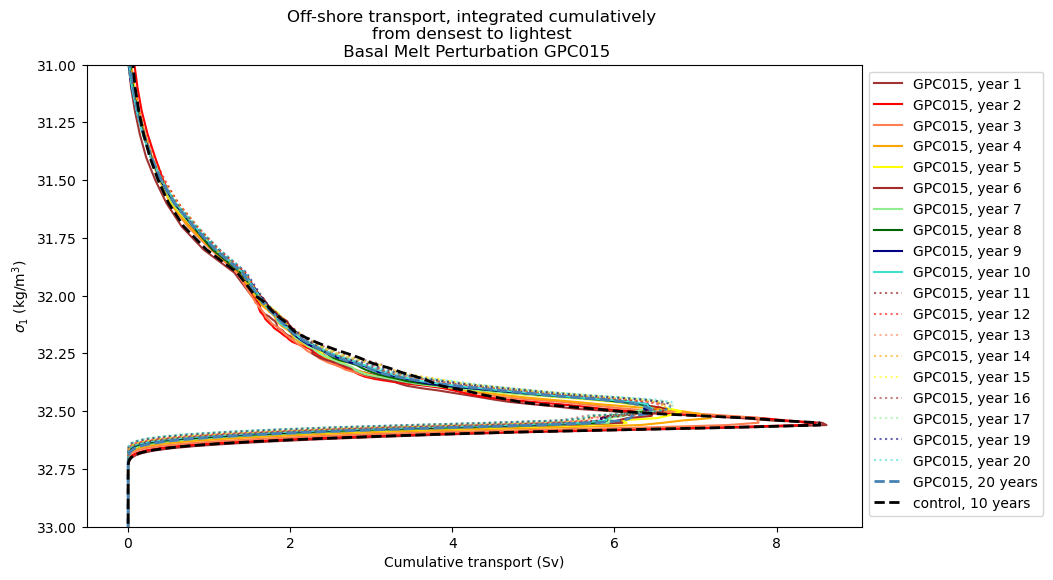

In [39]:
fig = plt.figure(figsize = (10,6))
# plot individual years in grey
b = (vol_trans_across_contour_GPC013_yr1/1e6).sum('contour_index')
(b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(y = 'isopycnal_bins', color = 'darkred',alpha = 0.8, label = 'GPC015, year 1')
b = (vol_trans_across_contour_GPC013_yr2/1e6).sum('contour_index')
(b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(y = 'isopycnal_bins', color = 'red',alpha = 1, label = 'GPC015, year 2')
b = (vol_trans_across_contour_GPC013_yr3/1e6).sum('contour_index')
(b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(y = 'isopycnal_bins', color = 'coral',alpha = 1, label = 'GPC015, year 3')
b = (vol_trans_across_contour_GPC013_yr4/1e6).sum('contour_index')
(b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(y = 'isopycnal_bins', color = 'orange',alpha = 1, label = 'GPC015, year 4')
b = (vol_trans_across_contour_GPC013_yr5/1e6).sum('contour_index')
(b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(y = 'isopycnal_bins', color = 'yellow',alpha = 1, label = 'GPC015, year 5')
b = (vol_trans_across_contour_GPC013_yr6/1e6).sum('contour_index')
(b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(y = 'isopycnal_bins', color = 'brown',alpha = 1, label = 'GPC015, year 6')
b = (vol_trans_across_contour_GPC013_yr7/1e6).sum('contour_index')
(b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(y = 'isopycnal_bins', color = 'lightgreen',alpha = 1, label = 'GPC015, year 7')
b = (vol_trans_across_contour_GPC013_yr8/1e6).sum('contour_index')
(b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(y = 'isopycnal_bins', color = 'darkgreen',alpha = 1, label = 'GPC015, year 8')
b = (vol_trans_across_contour_GPC013_yr9/1e6).sum('contour_index')
(b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(y = 'isopycnal_bins', color = 'navy',alpha = 1, label = 'GPC015, year 9')
b = (vol_trans_across_contour_GPC013_yr10/1e6).sum('contour_index')
(b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(y = 'isopycnal_bins', color = 'turquoise',alpha = 1, label = 'GPC015, year 10')

b = (vol_trans_across_contour_GPC013_yr11/1e6).sum('contour_index')
(b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(y = 'isopycnal_bins', color = 'darkred',alpha = 0.6, label = 'GPC015, year 11', linestyle = 'dotted')
b = (vol_trans_across_contour_GPC013_yr12/1e6).sum('contour_index')
(b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(y = 'isopycnal_bins', color = 'red',alpha = 0.6, label = 'GPC015, year 12', linestyle = 'dotted')
b = (vol_trans_across_contour_GPC013_yr13/1e6).sum('contour_index')
(b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(y = 'isopycnal_bins', color = 'coral',alpha = 0.6, label = 'GPC015, year 13', linestyle = 'dotted')
b = (vol_trans_across_contour_GPC013_yr14/1e6).sum('contour_index')
(b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(y = 'isopycnal_bins', color = 'orange',alpha = 0.6, label = 'GPC015, year 14', linestyle = 'dotted')
b = (vol_trans_across_contour_GPC013_yr15/1e6).sum('contour_index')
(b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(y = 'isopycnal_bins', color = 'yellow',alpha = 0.6, label = 'GPC015, year 15', linestyle = 'dotted')
b = (vol_trans_across_contour_GPC013_yr16/1e6).sum('contour_index')
(b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(y = 'isopycnal_bins', color = 'brown',alpha = 0.6, label = 'GPC015, year 16', linestyle = 'dotted')
b = (vol_trans_across_contour_GPC013_yr17/1e6).sum('contour_index')
(b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(y = 'isopycnal_bins', color = 'lightgreen',alpha = 0.6, label = 'GPC015, year 17', linestyle = 'dotted')
# b = (vol_trans_across_contour_GPC013_yr8/1e6).sum('contour_index')
# (b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(y = 'isopycnal_bins', color = 'darkgreen',alpha = 0.6, label = 'GPC015, year 8', linestyle = 'dotted')
b = (vol_trans_across_contour_GPC013_yr19/1e6).sum('contour_index')
(b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(y = 'isopycnal_bins', color = 'navy',alpha = 0.6, label = 'GPC015, year 19', linestyle = 'dotted')
b = (vol_trans_across_contour_GPC013_yr20/1e6).sum('contour_index')
(b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(y = 'isopycnal_bins', color = 'turquoise',alpha = 0.6, label = 'GPC015, year 20', linestyle = 'dotted')


# plot mean in blue
b = (vol_trans_across_contour_GPC015/1e6).sum('contour_index')
(b.sum('isopycnal_bins') -b.cumsum('isopycnal_bins')).plot(y = 'isopycnal_bins', label = 'GPC015, 20 years',color = 'steelblue', linestyle = '--',linewidth = 2)
#plot control in black
a = (vol_trans_across_contour/1e6).sum('contour_index')
(a.sum('isopycnal_bins') -a.cumsum('isopycnal_bins')).plot(y = 'isopycnal_bins', label = 'control, 10 years',color = 'k', linestyle = '--',linewidth = 2)

plt.ylim(33,31)
plt.xlabel('Cumulative transport (Sv)')
plt.ylabel('$\sigma_1$ (kg/m$^3$)')
plt.title('Off-shore transport, integrated cumulatively \nfrom densest to lightest \n Basal Melt Perturbation GPC015')
plt.legend(bbox_to_anchor = (1,1), loc = 'upper left')
#plt.savefig('offshore_transport_sum.png',dpi = 300)

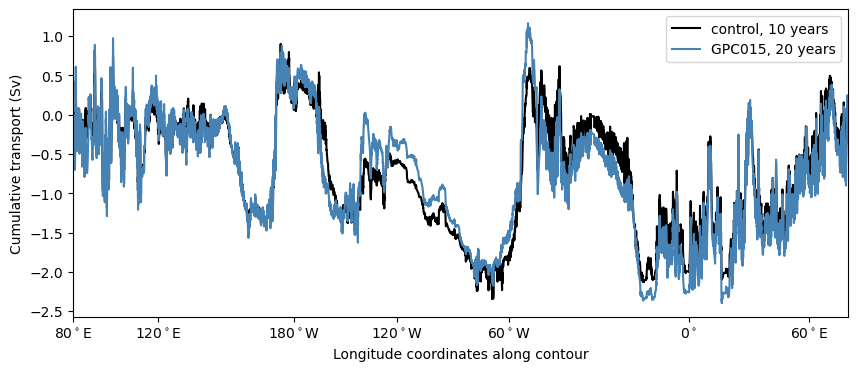

In [27]:
fig, axes = plt.subplots(figsize = (10,4))

axes.plot(distance_along_contour,(10**(-6)*vol_trans_across_contour.sum('isopycnal_bins').cumsum('contour_index')),label = 'control, 10 years', color = 'k')
axes.plot(distance_along_contour,(10**(-6)*vol_trans_across_contour_GPC015.sum('isopycnal_bins').cumsum('contour_index')),label = 'GPC015, 20 years',color = 'steelblue')
axes.set_ylabel('Cumulative transport (Sv)')
axes.set_xticks(distance_along_contour[distance_indices.astype(int)[:-1]])
axes.set_xticklabels(('80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'));
axes.set_xlim(0,distance_along_contour[-1]);
axes.set_xlabel('Longitude coordinates along contour')

plt.legend()
#plt.savefig('transport_cumsum.png',dpi = 300)

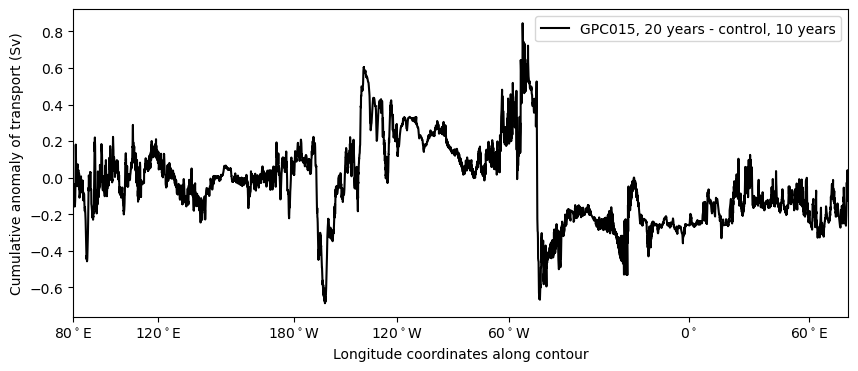

In [28]:
fig, axes = plt.subplots(figsize = (10,4))

axes.plot(distance_along_contour,(10**(-6)*(vol_trans_across_contour_GPC015-vol_trans_across_contour).sum('isopycnal_bins').cumsum('contour_index')),label = 'GPC015, 20 years - control, 10 years', color = 'k')
axes.set_ylabel('Cumulative anomaly of transport (Sv)')
axes.set_xticks(distance_along_contour[distance_indices.astype(int)[:-1]])
axes.set_xticklabels(('80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'));
axes.set_xlim(0,distance_along_contour[-1]);
axes.set_xlabel('Longitude coordinates along contour')
plt.legend()

### Plot time series of maximum depth and density over time

In [30]:
## load GPC013 transports as a time series

test = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/accessom2-GPC'+str(no).zfill(3)+'/Antarctic_cross_slope/vol_trans_across_contour_2150_01.nc').vol_trans_across_contour_binned
vol_trans_across_contour_GPC013_t = xr.zeros_like(test)
vol_trans_across_contour_GPC013_t  = vol_trans_across_contour_GPC013_t.expand_dims({"time":np.arange(240)})

count_days = 0
# load 3 year (3 years x 12 months)
for j in np.arange(2150,2170):
    for i in np.arange(1,13):
        if j == 2167:
            exit
        else:
            it = xr.open_mfdataset('/g/data/x77/cy8964/Post_Process/access-om2/accessom2-GPC'+str(no).zfill(3)+'/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
            it.load()
            vol_trans_across_contour_GPC013_t[i+12*(j-2150)-1,:,:] = it.vol_trans_across_contour_binned #*it.ndays
            count_days = count_days + it.ndays.values
            #print(i+12*(j-2150)-1)
# divide by total of number of days in each month for correct annual average    
#vol_trans_across_contour_GPC008 = vol_trans_across_contour_GPC008/count_days
#vol_trans_across_contour_GPC008

In [32]:
## load control transports as a time series

test = xr.open_mfdataset('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_rerun_for_easterlies/Antarctic_cross_slope/vol_trans_across_contour_2150_01.nc').vol_trans_across_contour_binned
vol_trans_across_contour_control_t = xr.zeros_like(test)
vol_trans_across_contour_control_t  = vol_trans_across_contour_control_t.expand_dims({"time":np.arange(120)})

count_days = 0
# load 3 year (3 years x 12 months)
for j in np.arange(2150,2160):
    for i in np.arange(1,13):
        it = xr.open_mfdataset('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_rerun_for_easterlies/Antarctic_cross_slope/vol_trans_across_contour_'+str(j)+'_'+str(i).zfill(2)+'.nc')
        it.load()
        vol_trans_across_contour_control_t[i+12*(j-2150)-1,:,:] = it.vol_trans_across_contour_binned #*it.ndays
        count_days = count_days + it.ndays.values
        #print(i+12*(j-2150)-1)


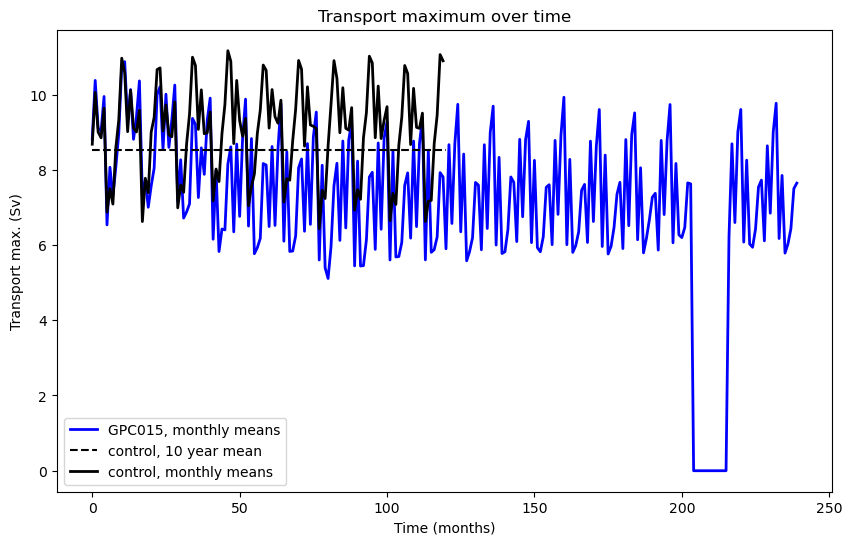

In [33]:
fig = plt.figure(figsize = (10,6))
# plot monthly transport max for perturbation
a = (vol_trans_across_contour_GPC013_t/1e6).sum('contour_index')
(a.sum('isopycnal_bins') -a.cumsum('isopycnal_bins')).max('isopycnal_bins').plot(label = 'GPC015, monthly means',color = 'b', linewidth = 2)
# plot mean transport max for control
c = (vol_trans_across_contour/1e6).sum('contour_index')
b = (c.sum('isopycnal_bins') -c.cumsum('isopycnal_bins')).max('isopycnal_bins')
plt.hlines(b, 0,120, color = 'k', label = 'control, 10 year mean', linestyle = "--")
# plot monthly transport max for control
a = (vol_trans_across_contour_control_t/1e6).sum('contour_index')
(a.sum('isopycnal_bins') -a.cumsum('isopycnal_bins')).max('isopycnal_bins').plot(label = 'control, monthly means',color = 'k', linewidth = 2)

plt.ylabel('Transport max. (Sv)')
plt.xlabel('Time (months)')
plt.title('Transport maximum over time')
plt.legend()

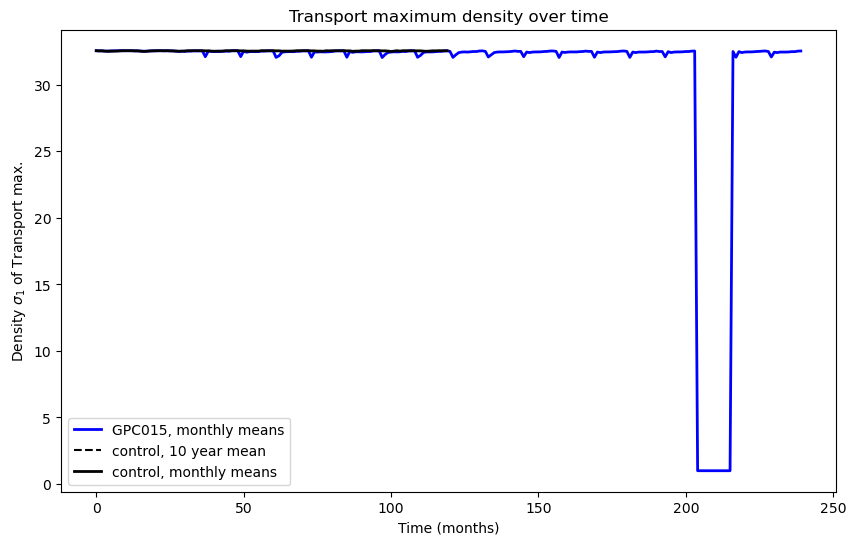

In [34]:
fig = plt.figure(figsize = (10,6))
# plot monthly transport max density for perturbation
a = (vol_trans_across_contour_GPC013_t/1e6).sum('contour_index')
(a.sum('isopycnal_bins') -a.cumsum('isopycnal_bins')).idxmax('isopycnal_bins').plot(label = 'GPC015, monthly means',color = 'b', linewidth = 2)
# plot mean transport max density for control
c = (vol_trans_across_contour/1e6).sum('contour_index')
b = (c.sum('isopycnal_bins') -c.cumsum('isopycnal_bins')).idxmax('isopycnal_bins')
plt.hlines(b, 0,120, color = 'k', label = 'control, 10 year mean', linestyle = '--')
# plot monthly transport max density for control
a = (vol_trans_across_contour_control_t/1e6).sum('contour_index')
(a.sum('isopycnal_bins') -a.cumsum('isopycnal_bins')).idxmax('isopycnal_bins').plot(label = 'control, monthly means',color = 'k', linewidth = 2)

plt.ylabel('Density $\sigma_1$ of Transport max.')
plt.xlabel('Time (months)')
plt.title('Transport maximum density over time')
plt.legend()

### Transport cumulative sums for different density classes


Text(0.5, 1.0, '$\\sigma_1$ > 32.56')

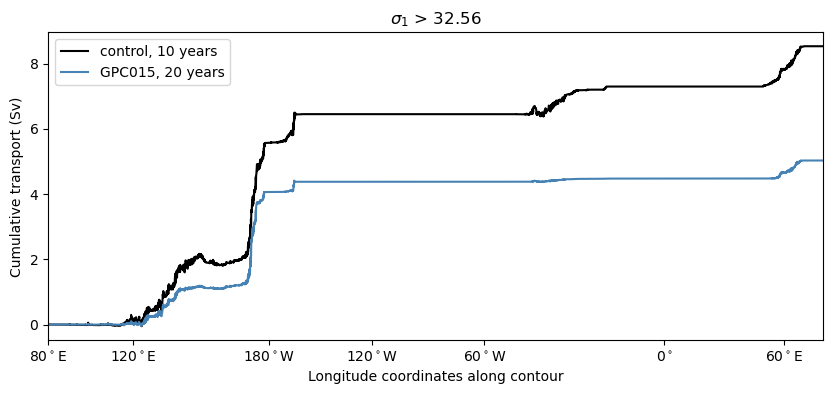

In [35]:
fig, axes = plt.subplots(figsize = (10,4))

axes.plot(distance_along_contour,(10**(-6)*vol_trans_across_contour.sel(isopycnal_bins = slice(32.56,40)).sum('isopycnal_bins').cumsum('contour_index')),label = 'control, 10 years', color = 'k')
axes.plot(distance_along_contour,(10**(-6)*vol_trans_across_contour_GPC015.sel(isopycnal_bins = slice(32.56,40)).sum('isopycnal_bins').cumsum('contour_index')),label = 'GPC015, 20 years',color = 'steelblue')
axes.set_ylabel('Cumulative transport (Sv)')
axes.set_xticks(distance_along_contour[distance_indices.astype(int)[:-1]])
axes.set_xticklabels(('80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'));
axes.set_xlim(0,distance_along_contour[-1]);
axes.set_xlabel('Longitude coordinates along contour')

plt.legend()
plt.title('$\sigma_1$ > 32.56')

Text(0.5, 1.0, '32.4 < $\\sigma_1$ < 32.56')

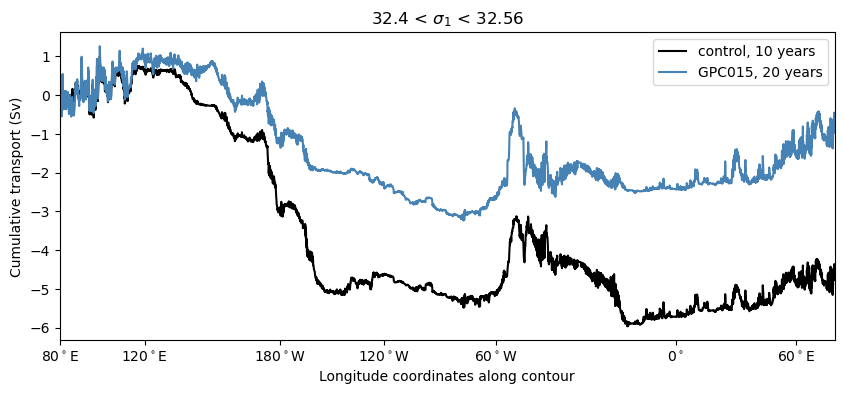

In [36]:
fig, axes = plt.subplots(figsize = (10,4))

axes.plot(distance_along_contour,(10**(-6)*vol_trans_across_contour.sel(isopycnal_bins = slice(32.4,32.56)).sum('isopycnal_bins').cumsum('contour_index')),label = 'control, 10 years', color = 'k')
axes.plot(distance_along_contour,(10**(-6)*vol_trans_across_contour_GPC015.sel(isopycnal_bins = slice(32.4,32.56)).sum('isopycnal_bins').cumsum('contour_index')),label = 'GPC015, 20 years',color = 'steelblue')
axes.set_ylabel('Cumulative transport (Sv)')
axes.set_xticks(distance_along_contour[distance_indices.astype(int)[:-1]])
axes.set_xticklabels(('80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'));
axes.set_xlim(0,distance_along_contour[-1]);
axes.set_xlabel('Longitude coordinates along contour')

plt.legend()
plt.title('32.4 < $\sigma_1$ < 32.56')

Text(0.5, 1.0, '$\\sigma_1$ < 32.4')

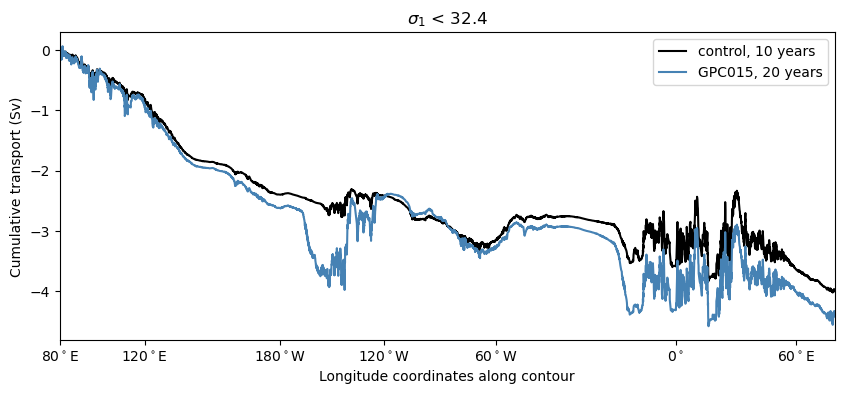

In [37]:
fig, axes = plt.subplots(figsize = (10,4))

axes.plot(distance_along_contour,(10**(-6)*vol_trans_across_contour.sel(isopycnal_bins = slice(0,32.4)).sum('isopycnal_bins').cumsum('contour_index')),label = 'control, 10 years', color = 'k')
axes.plot(distance_along_contour,(10**(-6)*vol_trans_across_contour_GPC015.sel(isopycnal_bins = slice(0, 32.4)).sum('isopycnal_bins').cumsum('contour_index')),label = 'GPC015, 20 years',color = 'steelblue')
axes.set_ylabel('Cumulative transport (Sv)')
axes.set_xticks(distance_along_contour[distance_indices.astype(int)[:-1]])
axes.set_xticklabels(('80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'));
axes.set_xlim(0,distance_along_contour[-1]);
axes.set_xlabel('Longitude coordinates along contour')

plt.legend()
plt.title('$\sigma_1$ < 32.4')

Text(0.5, 0, 'Longitude coordinates along contour')

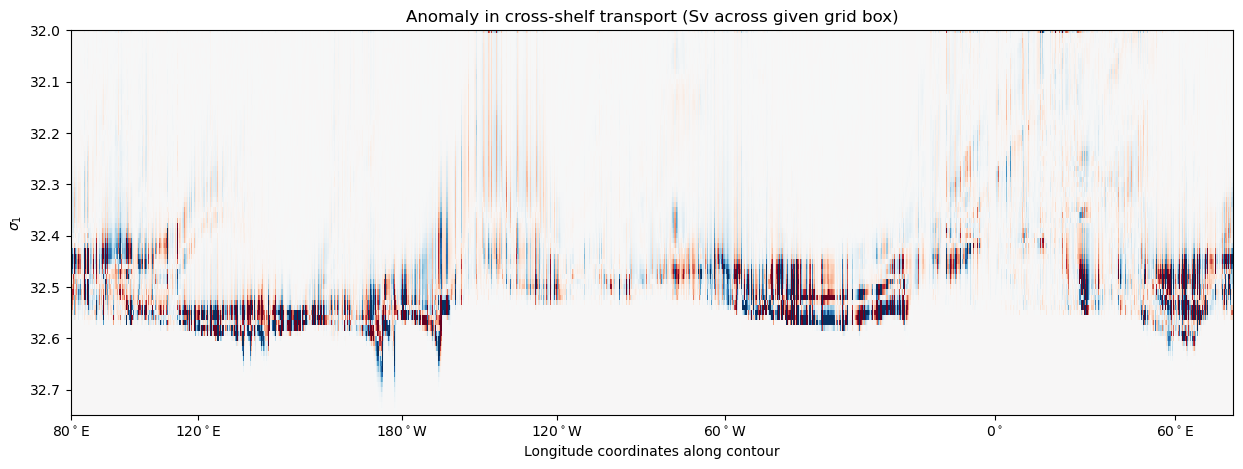

In [38]:
fig,axes = plt.subplots(figsize = (15,5))
plt.pcolormesh(distance_along_contour,vol_trans_across_contour_GPC015.isopycnal_bins,vol_trans_across_contour_GPC015-vol_trans_across_contour, vmax = 10000, vmin = -10000, cmap = 'RdBu_r')
plt.ylim(32.75,32)
plt.ylabel('$\sigma_1$')
plt.title('Anomaly in cross-shelf transport (Sv across given grid box)')
axes.set_xticks(distance_along_contour[distance_indices.astype(int)[:-1]])
axes.set_xticklabels(('80$^\circ$E','120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'));
axes.set_xlim(0,distance_along_contour[-1]);
axes.set_xlabel('Longitude coordinates along contour')


Amundsen: -125 to -100 E = 125-100W

A lot of places have blue colours at lower densities and red colours at higher -> low densities more southward -> less bottom water northward 
